In [1]:
'''
Code for the simulation study result in paper "Tensor Gaussian Process with Contraction for Multi-Channel Imaging Analysis"
'''

# built-in packages for tensor operations & optimization
import numpy as np
import pandas as pd
import prox_tv as ptv # package for solving the fused-lasso problem in the proximal step (see the installation guide at: https://github.com/albarji/proxTV)
import copy, math, sys, os, random, types, collections


# self-developed module for simulation data generation and implementing the model
from utils import *
from Simulation_Mod import Simulation # import the function for generating the simulation data
from model import TensorGPST, TensorGP # import the Tensor-GPST model and Tensor-GP model
from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor


# packages for visualizing the results
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rc('image', cmap='Reds') # set default colormap as red vs. white

### 1. Simulation Data Example

In [2]:
sim_param = {'N': 500, # total sample size
             'sigma': 0.5, # idiosyncratic noise
             'train_ratio': 0.75} # training set ratio

data = Simulation(sim_param, seed = 1) # generate the simulation data

#### 1.1 Visualize Samples

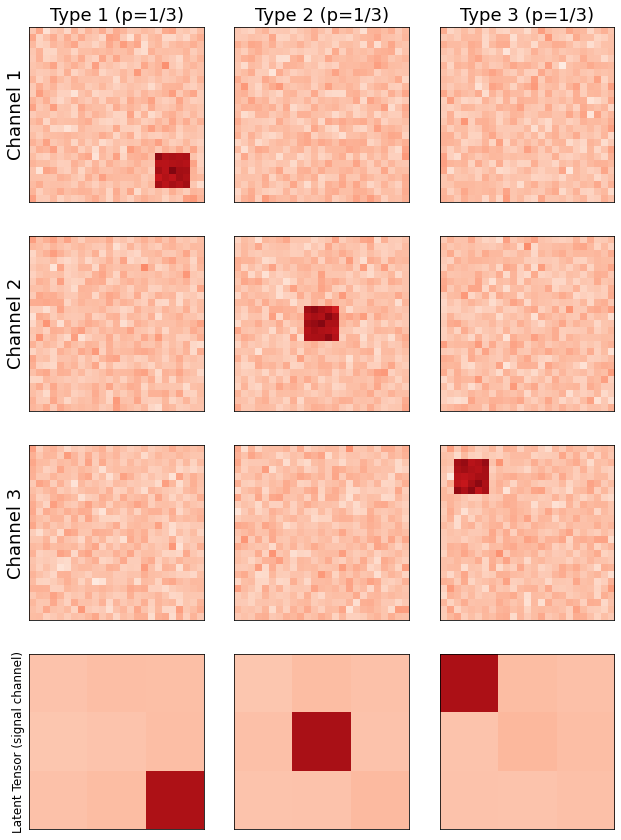

In [3]:
lbsize = 18


### Figure I: Example Patterns
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (9,12));

ax[0,0].imshow(data.X[2,0], vmin = -1.5, vmax = 5);
ax[1,0].imshow(data.X[2,1], vmin = -1.5, vmax = 5);
ax[2,0].imshow(data.X[2,2], vmin = -1.5, vmax = 5);

ax[0,1].imshow(data.X[0,0], vmin = -1.5, vmax = 5);
ax[1,1].imshow(data.X[0,1], vmin = -1.5, vmax = 5);
ax[2,1].imshow(data.X[0,2], vmin = -1.5, vmax = 5);

ax[0,2].imshow(data.X[1,0], vmin = -1.5, vmax = 5);
ax[1,2].imshow(data.X[1,1], vmin = -1.5, vmax = 5);
ax[2,2].imshow(data.X[1,2], vmin = -1.5, vmax = 5);

ax[3,0].imshow(data.A @ data.X[2,0] @ data.B.T, vmin = -1.5, vmax = 5);
ax[3,1].imshow(data.A @ data.X[0,1] @ data.B.T, vmin = -1.5, vmax = 5);
ax[3,2].imshow(data.A @ data.X[1,2] @ data.B.T, vmin = -1.5, vmax = 5);

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].xaxis.set_major_locator(ticker.NullLocator());
        ax[i,j].yaxis.set_major_locator(ticker.NullLocator());

ax[0,0].set_title("Type 1 (p=1/3)", size = lbsize);
ax[0,1].set_title("Type 2 (p=1/3)", size = lbsize);
ax[0,2].set_title("Type 3 (p=1/3)", size = lbsize);
ax[0,0].set_ylabel("Channel 1", size = lbsize);
ax[1,0].set_ylabel("Channel 2", size = lbsize);
ax[2,0].set_ylabel("Channel 3", size = lbsize);
ax[3,0].set_ylabel("Latent Tensor (signal channel)", size = 12);
plt.tight_layout();

#### 1.2 Train Tensor-GPST Model

In [4]:
algo_params = {'N-train': 375, # training data size
               'N-test': 125, # testing data size
               'Latent-Dim': (3,3), # h, w
               'Latent-Rank': (3,3,3), # r_{1}, r_{2}, r_{3}
               'lambda': 1.0, # Total-Variation penalty tuning parameter (1.0 for GPST-high, 0.1 for GPST-low, further tuning can be done with CV)
               'Init-A': "random", # update A with random initialization
               'Init-B': "random", # update B with random initialization
               'Init-U': "random", # update U_{1}, U_{2}, U_{3} with random initialization                
               'sigma-init': "random", # update sigma with random initialization
               'plot': True, # whether to plot the loss history
               'seed': 2023}

model = TensorGPST(param = algo_params, data = data) # create a model object with the configuration above

Iter = 100, NLL = 143.6267, TV-Penalty = 48.2186, Delta = 0.012748, sigma = 0.6289
Iter = 200, NLL = 169.1902, TV-Penalty = 17.7213, Delta = 0.00508, sigma = 0.5403


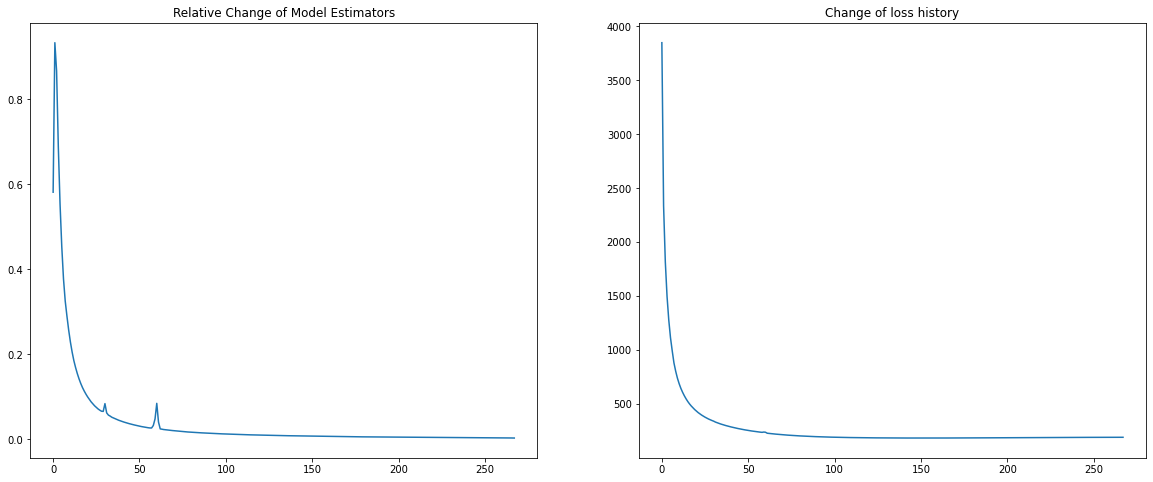

In [5]:
# can take ~ 1 min to converge on personal laptop (e.g. MacBook Air)
model.fit(max_iter = 2000, # maximum iteration
          lr = 1e-4, # constant learning rate
          tol = np.sqrt(1e-5), # convergence threshold (sum of l-2 norm change of all model parameters)
          print_freq = 100 # print the loss information for each iteration
         )

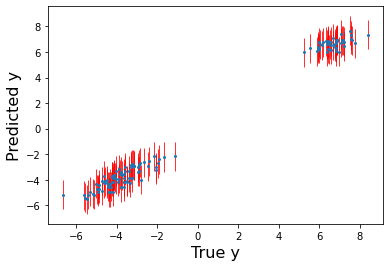

In [6]:
# plot the test set regression result with 95% confidence band
plt.errorbar(data.test_y, model.y_pred[:,0], ecolor = "r", elinewidth = 0.8, fmt="o", markersize=2,
             yerr=1.96*np.sqrt(np.diagonal(model.y_pred_s2) + model.sigma**2), # in the model, the yerr is computed without adding the estimated variance of the noise, we add them back at the prediction stage
             ls = "None");
plt.xlabel("True y", size=16);
plt.ylabel("Predicted y", size=16);


In [7]:
model_summary(model, data)

,Type,MSE,R-sqaured,TSS,Coverage
0,training,0.2543,0.9901,1.0,98.1333
1,testing,0.2518,0.9905,1.0,97.6000


### 2. Model Comparison

**Notes**: The following block runs 10 iterations of the simulation experiment across five methods compared in Section 3.1 of the paper. Each iteration can take ~ 10 minutes. Sample size is 200. For simplicity, we fit two versions of GPST here, one with lambda=0.1, called GPST-low, and one with lambda=1.0, called GPST-high.

In [7]:
results_train, results_test, cover_train, cover_test = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
sim_param = {'N': 200, 'sigma': 0.5, 'train_ratio': 0.75}


for iteration in range(10): # number of iteration = 10
    # generate simulation data
    data = Simulation(sim_param, seed = 2000+iteration)
    
    # ------------------------ #
    # ----- Fit GPST-low ----- #
    # ------------------------ #
    print("Fitting GPST-low...")
    algo_params = {'N-train': math.ceil(sim_param['train_ratio'] * sim_param['N']), 
               'N-test': math.ceil((1 - sim_param['train_ratio']) * sim_param['N']),
               'Latent-Dim': (3,3),
               'Latent-Rank': (3,3,3),
               'lambda': 0.1,
               'Init-A': "random",
               'Init-B': "random",
               'Init-U': "random",               
               'sigma-init': "random",
               'plot': False,
               'seed': 2022}
    
    model = TensorGPST(param = algo_params, data = data)
    model.fit(max_iter = 2000, lr = 1e-4, tol = 1e-3, print_freq = 5000)
    train_MSE, test_MSE = np.mean((model.y_train_pred[:,0] - data.train_y)**2), np.mean((model.y_pred[:,0] - data.test_y)**2) # train/test MSE
    train_prob, test_prob = coverage_probability(model, data) # train/test coverage
    
    results_train['GPST-low'].append(train_MSE)
    results_test['GPST-low'].append(test_MSE)
    cover_train['GPST-low'].append(train_prob)
    cover_test['GPST-low'].append(test_prob)
    
    # ------------------------ #
    # ----- Fit GPST-high ---- #
    # ------------------------ #
    print("Fitting GPST-high...")
    algo_params['lambda'] = 1.0
    model = TensorGPST(param = algo_params, data = data)
    model.fit(max_iter = 2000, lr = 1e-4, tol = 1e-3, print_freq = 5000)
    train_MSE, test_MSE = np.mean((model.y_train_pred[:,0] - data.train_y)**2), np.mean((model.y_pred[:,0] - data.test_y)**2) # train/test MSE
    train_prob, test_prob = coverage_probability(model, data) # train/test coverage
    results_train['GPST-high'].append(train_MSE)
    results_test['GPST-high'].append(test_MSE)
    cover_train['GPST-high'].append(train_prob)
    cover_test['GPST-high'].append(test_prob)
    
    
    # ------------------------ #
    # ----- Fit GPST-Hard ---- #
    # ------------------------ #
    # GPST-hard assumes that the sparsity structure of the tensor contracting factors are known
    print("Fitting GPST-Hard...")
    algo_params['lambda'] = 0.0
    algo_params['Init-A'] = "hard"
    algo_params['Init-B'] = "hard"
    model = TensorGPST(param = algo_params, data = data)
    model.fit(max_iter = 2000, lr = 1e-4, tol = 1e-3, print_freq = 5000)
    train_MSE, test_MSE = np.mean((model.y_train_pred[:,0] - data.train_y)**2), np.mean((model.y_pred[:,0] - data.test_y)**2) # train/test MSE
    train_prob, test_prob = coverage_probability(model, data) # train/test coverage
    results_train['GPST-Hard'].append(train_MSE)
    results_test['GPST-Hard'].append(test_MSE)
    cover_train['GPST-Hard'].append(train_prob)
    cover_test['GPST-Hard'].append(test_prob)
    
    
    # ------------------------------- #
    # -------- Fit Tensor-GP -------- #
    # ------------------------------- #
    print("Fitting GP...")
    algo_params = {'N-train': math.ceil(sim_param['train_ratio'] * sim_param['N']), 
               'N-test': math.ceil((1 - sim_param['train_ratio']) * sim_param['N']),
               'Latent-Rank': (3,3,3),
               'plot': False,
               'seed': 2022}

    Tensor_GP_regression = TensorGP(param = algo_params, data = data)
    Tensor_GP_regression.fit(max_iter = 2000, lr = 1e-4, tol = np.sqrt(1e-5), print_freq = 5000)
    train_MSE, test_MSE = np.mean((Tensor_GP_regression.y_train_pred[:,0] - data.train_y)**2), np.mean((Tensor_GP_regression.y_pred[:,0] - data.test_y)**2) # train/test MSE
    train_prob, test_prob = coverage_probability(Tensor_GP_regression, data) # train/test coverage
    results_train['GP'].append(train_MSE)
    results_test['GP'].append(test_MSE)
    cover_train['GP'].append(train_prob)
    cover_test['GP'].append(test_prob)
    
    
    # ------------------------ #
    # -------- Fit CP -------- #
    # ------------------------ #
    print("Fitting CP...")
    CP_tensor_regression_model = CPRegressor(weight_rank=9, reg_W=30) # 30 empirically works well
    CP_tensor_regression_model.fit(data.train_X, data.train_y);
    CP_train_pred = CP_tensor_regression_model.predict(data.train_X)
    CP_pred = CP_tensor_regression_model.predict(data.test_X)
    train_MSE, test_MSE = np.mean((CP_train_pred - data.train_y)**2), np.mean((CP_pred - data.test_y)**2)
    results_train['CP'].append(train_MSE)
    results_test['CP'].append(test_MSE)
    
    # ------------------------ #
    # ------ Fit Tucker ------ #
    # ------------------------ #
    print("Fitting Tucker...")
    Tucker_tensor_regression_model = TuckerRegressor(weight_ranks=[3, 3, 3], reg_W=30) # 30 empirically works well
    Tucker_tensor_regression_model.fit(data.train_X, data.train_y);
    Tucker_train_pred = Tucker_tensor_regression_model.predict(data.train_X)
    Tucker_pred = Tucker_tensor_regression_model.predict(data.test_X)
    train_MSE, test_MSE = np.mean((Tucker_train_pred - data.train_y)**2), np.mean((Tucker_pred - data.test_y)**2)
    results_train['Tucker'].append(train_MSE)
    results_test['Tucker'].append(test_MSE)
    
    print(f"Iteration {iteration} done.")

Fitting GPST-low...
Fitting GPST-high...
Fitting GPST-Hard...
Fitting GP...
Fitting CP...
Fitting Tucker...
Iteration 0 done.
Fitting GPST-low...
Fitting GPST-high...
Fitting GPST-Hard...
Fitting GP...
Fitting CP...

Converged in 67 iterations
Fitting Tucker...
Iteration 1 done.
Fitting GPST-low...
Fitting GPST-high...
Fitting GPST-Hard...
Fitting GP...
Fitting CP...

Converged in 91 iterations
Fitting Tucker...
Iteration 2 done.
Fitting GPST-low...
Fitting GPST-high...
Fitting GPST-Hard...
Fitting GP...
Fitting CP...
Fitting Tucker...
Iteration 3 done.
Fitting GPST-low...
Fitting GPST-high...
Fitting GPST-Hard...
Fitting GP...
Fitting CP...

Converged in 91 iterations
Fitting Tucker...
Iteration 4 done.
Fitting GPST-low...
Fitting GPST-high...
Fitting GPST-Hard...
Fitting GP...
Fitting CP...

Converged in 42 iterations
Fitting Tucker...

Converged in 35 iterations
Iteration 5 done.
Fitting GPST-low...
Fitting GPST-high...
Fitting GPST-Hard...
Fitting GP...
Fitting CP...
Fitting Tucker

In [10]:
pd.concat([pd.DataFrame(results_train, index=list(range(1,11))), pd.DataFrame(results_test, index=list(range(1,11)))])

,GPST-low,GPST-high,GPST-Hard,GP,CP,Tucker
1,0.197801,0.252015,0.258372,0.259346,0.242021,0.259077
2,0.181252,0.227451,0.264605,0.287218,0.222085,0.266689
3,0.180108,0.208385,0.277503,0.355710,0.207082,0.203549
4,0.202462,0.225410,0.260069,0.305291,0.265311,0.373407
5,0.218161,0.197307,0.248605,0.290894,0.205845,0.241661
6,0.237839,0.262068,0.257920,0.324590,0.275350,0.283350
7,0.213655,0.256258,0.325011,0.330945,0.280200,0.252561
8,0.266064,0.293670,0.326744,0.260052,0.303089,0.298002
9,0.256919,0.272233,0.286556,0.383843,0.284993,0.292121
10,0.224322,0.267352,0.347610,0.310244,0.263634,0.262100


In [11]:
pd.concat([pd.DataFrame(cover_train, index=list(range(1,11))), pd.DataFrame(cover_test, index=list(range(1,11)))]) # this computes the coverage probability of the variants GP models

,GPST-low,GPST-high,GPST-Hard,GP
1,0.980000,0.966667,0.973333,0.960000
2,0.986667,0.973333,0.980000,0.993333
3,0.986667,0.973333,0.980000,0.980000
4,0.966667,0.973333,0.986667,0.993333
5,0.986667,0.973333,0.973333,1.000000
6,0.953333,0.960000,0.986667,0.973333
7,0.973333,0.973333,0.980000,0.993333
8,0.980000,0.980000,0.980000,0.960000
9,0.960000,0.973333,0.986667,0.960000
10,0.980000,0.966667,0.980000,0.993333
